In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from time import time
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
import math

def bb(A,T_inff,times):
  return A - A*times/(2*T_inff)

def simulation_us(num_simulations, time_steps,drift_rate1, boundary_separation,t_00, starting_point, noise_std, dt):
  # Arrays to store results
  decision_times1 = []
  decision_times2 = []
  no_decision = []

  for i in range(num_simulations):
      # Initialize decision variable
      decision_variable = starting_point
      for t in range(time_steps):
          # Update decision variable with drift and noise
          noise = np.random.normal(0, noise_std)
          decision_variable += drift_rate1 * dt + noise * np.sqrt(dt)

          # Check if decision boundary is crossed
          if decision_variable >= bb(boundary_separation,t_00,t*dt):
              decision_times1.append(t * dt)
              break
          elif decision_variable <= -bb(boundary_separation,t_00,t*dt):
              decision_times2.append(t * dt)
              break
      else:
          # If no decision is made within time_steps, record maximum time
          no_decision.append(time_steps * dt)
  return decision_times1,decision_times2

def bb(A, T_inff, t):

    return A - A * t / (2.0 * T_inff)

def _drift_eval(drift, t, x):

    if callable(drift):
        return float(drift(t, x))
    return float(drift)

def _first_passage_time_linear(x0, x1, t0, dt, A, T_inff, upper=True, max_iter=20):

    s = 1.0 if upper else -1.0

    def x_tau(tau):

        return x0 + (x1 - x0) * (tau / dt)

    def g(tau):
        return x_tau(tau) - s * bb(A, T_inff, t0 + tau)

    g0, g1 = g(0.0), g(dt)

    if g0 == 0.0:
        return t0
    if g0 * g1 > 0.0:
        return None

    lo, hi = 0.0, dt
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        gm = g(mid)
        if gm == 0.0:
            return t0 + mid
        if g0 * gm < 0.0:
            hi = mid
            g1 = gm
        else:
            lo = mid
            g0 = gm
    return t0 + 0.5 * (lo + hi)

def simulation_us_rk4(
    num_simulations,
    time_steps,
    drift,
    boundary_separation,
    T_inff,
    starting_point,
    noise_std,
    dt,
    seed=None
):

    rng = np.random.default_rng(seed)

    decision_times1 = []
    decision_times2 = []
    no_decision = []

    for _ in range(num_simulations):
        x = float(starting_point)
        decided = False

        for n in range(time_steps):
            t = n * dt


            upper_now = bb(boundary_separation, T_inff, t)
            lower_now = -upper_now


            k1 = _drift_eval(drift, t, x)
            k2 = _drift_eval(drift, t + 0.5*dt, x + 0.5*dt*k1)
            k3 = _drift_eval(drift, t + 0.5*dt, x + 0.5*dt*k2)
            k4 = _drift_eval(drift, t + dt,     x + dt*k3)
            drift_increment = (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)


            dW = rng.normal(0.0, np.sqrt(dt))
            noise_increment = noise_std * dW

            x_new = x + drift_increment + noise_increment


            upper_next = bb(boundary_separation, T_inff, t + dt)
            lower_next = -upper_next

            crossed_upper = (x >= upper_now) or (x_new >= upper_next)
            crossed_lower = (x <= lower_now) or (x_new <= lower_next)

            if crossed_upper or crossed_lower:
                if crossed_upper:
                    tau_time = _first_passage_time_linear(
                        x0=x, x1=x_new, t0=t, dt=dt,
                        A=boundary_separation, T_inff=T_inff, upper=True
                    )
                    if tau_time is None:
                        tau_time = t + dt
                    decision_times1.append(tau_time)
                else:
                    tau_time = _first_passage_time_linear(
                        x0=x, x1=x_new, t0=t, dt=dt,
                        A=boundary_separation, T_inff=T_inff, upper=False
                    )
                    if tau_time is None:
                        tau_time = t + dt
                    decision_times2.append(tau_time)

                decided = True
                break
            x = x_new

        if not decided:
            no_decision.append(time_steps * dt)

    return decision_times1, decision_times2
# Define model architecture
class PINN_NeuralNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
            output_dim=1,
            num_hidden_layers=5,
            num_neurons_per_layer=50,
            activation='tanh',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        ## Define NN architecture
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers-1)]
        self.hidden1 = tf.keras.layers.Dense(num_neurons_per_layer,activation = 'softplus')
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, X):
        """Forward-pass through neural network."""
        Z = X
        for i in range(self.num_hidden_layers-1):
            Z = self.hidden[i](Z)
        #Z = self.hidden1(Z)
        return self.out(Z)

class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
        self.lambd0 = self.add_weight(name="lambd0", initializer="ones" ,trainable=True, dtype=tf.float32)
        self.t_inf = self.add_weight(name="t_inf", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.a = self.add_weight(name="a", initializer= tf.keras.initializers.Constant(3.0) ,trainable=True, dtype=tf.float32)
        self.tt0 = self.add_weight(name="tt0", initializer="ones" ,trainable=True, dtype=tf.float32)
        self.lambd0_list = []
        self.t_inf_list = []
        self.a_list = []
        self.tt0_list = []

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=False) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape
        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X,xmax,rt1,rt2, u):
        # Compute phi_r
        r= self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss_r = phi_r

        # Add phi_0 and phi_b to the loss

        u_pred = self.model(X[0])
        loss_0 = tf.reduce_mean(tf.square(u[0] - u_pred))
        #loss_0 = tf.reduce_mean(tf.square(tfp.math.trapz(u_pred, x=X[0][:,1:2])-1))

        u_pred = self.model(X[1])
        loss_b = tf.reduce_mean(tf.square(u[1] - u_pred))

        tspace1 = np.sort(rt1)
        tspace2 = np.sort(rt2)
        tspace_tf1 = tf.constant(tspace1.reshape((len(rt1),1)),'float32')
        minRT1 = min(rt1)
        minRT2 = min(rt2)
        self.minRT = min(minRT1,minRT2)
        t1 = tspace_tf1 - tf.math.sigmoid(self.model.tt0)*self.minRT


        xspace = np.ones((len(tspace1),1))*xmax
        xtf = tf.constant(xspace,'float32')
        X = tf.concat([t1,xtf],1)
        p_i =  self.model(X)

        xspace1 = np.ones((len(tspace1),1))*(xmax-0.02)
        xtf1 = tf.constant(xspace1,'float32')
        X1 = tf.concat([t1,xtf1],1)
        p_ii =  self.model(X1)

        xspace2 = np.ones((len(tspace1),1))*(xmax-0.04)
        xtf2 = tf.constant(xspace2,'float32')
        X2 = tf.concat([t1,xtf2],1)
        p_iii =  self.model(X2)
        bt1 = self.model.a - (self.model.a*t1)/(2*self.model.t_inf)

        mu1 =  tf.nn.softplus(self.model.lambd0)/bt1 - (xmax*(-self.model.a/(2*self.model.t_inf)))/bt1
        ddx = xmax*bt1 - (xmax-0.02)*bt1
        p_x = (3*p_i-4*p_ii+p_iii)/(2*ddx)
        J1 = mu1* p_i -0.5*p_x
        kde1 = gaussian_kde(tspace1)
        p_kde1 = len(tspace1)*kde1(tspace1)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor1 = tf.convert_to_tensor(p_kde1, dtype=tf.float32)
        KDE_loss1 = tf.reduce_mean(tf.square(J1 - p_kde_tensor1))

#####################################################3
        tspace_tf2 = tf.constant(tspace2.reshape((len(rt2),1)),'float32')

        t2 = tspace_tf2 - tf.math.sigmoid(self.model.tt0)*self.minRT


        xspace20 = np.ones((len(tspace2),1))*(-xmax)
        xtf20 = tf.constant(xspace20,'float32')
        X20 = tf.concat([t2,xtf20],1)
        p_i2 =  self.model(X20)

        xspace21 = np.ones((len(tspace2),1))*(-xmax+0.02)
        xtf21 = tf.constant(xspace21,'float32')
        X21 = tf.concat([t2,xtf21],1)
        p_ii2 =  self.model(X21)

        xspace22 = np.ones((len(tspace2),1))*(-xmax+0.04)
        xtf22 = tf.constant(xspace22,'float32')
        X22 = tf.concat([t2,xtf22],1)
        p_iii2 =  self.model(X22)
        bt2 = (self.model.a - (self.model.a*t2)/(2*self.model.t_inf))
        mu2 =  tf.nn.softplus(self.model.lambd0)/bt2 - (-xmax*(-self.model.a/(2*self.model.t_inf)))/bt2
        dddx = xmax*bt2 - (xmax-0.02)*bt2

        p_x2 = (-3*p_i2+4*p_ii2 -p_iii2)/(2*dddx)

        J2 = mu2* p_i2 -0.5*p_x2 ##
        kde2 = gaussian_kde(tspace2)
        p_kde2 = -len(tspace2)*kde2(tspace2)[:, np.newaxis]/(len(tspace2)+len(tspace1))
        p_kde_tensor2 = tf.convert_to_tensor(p_kde2, dtype=tf.float32)
        KDE_loss2 = tf.reduce_mean(tf.square(J2 - p_kde_tensor2))

        return 10*(loss_r+loss_0+loss_b) + KDE_loss1 + KDE_loss2


    def get_grad(self, X,xmax,rt1,rt2, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            #tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X,xmax,rt1,rt2, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape
        return loss, g

    #def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
     #   return u_t + tf.nn.softplus(self.model.lambd)*u_x - 0.5 *(tf.nn.softplus(self.model.sig))**2* u_xx

    def solve_with_TFoptimizer(self, optimizer, X,xmax,rt1,rt2, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X,xmax,rt1,rt2, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def solve_with_ScipyOptimizer(self, X,rt, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in Fortran
        which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
            for v in self.model.variables:
                shape_list.append(v.shape)
                weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list

        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0
            for v in self.model.variables:
                vs = v.shape

                # Weight matrices
                if len(vs) == 2:
                    sw = vs[0]*vs[1]
                    new_val = tf.reshape(weight_list[idx:idx+sw],(vs[0],vs[1]))
                    idx += sw

                # Bias vectors
                elif len(vs) == 1:
                    new_val = weight_list[idx:idx+vs[0]]
                    idx += vs[0]

                # Variables (in case of parameter identification setting)
                elif len(vs) == 0:
                    new_val = weight_list[idx]
                    idx += 1

                # Assign variables (Casting necessary since scipy requires float64 type)
                v.assign(tf.cast(new_val, 'float32'))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from scipy."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad(X,rt, u)

            # Store current loss for callback function
            loss = loss.numpy().astype(np.float64)
            self.current_loss = loss

            # Flatten gradient
            grad_flat = []
            for g in grad:
                grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
            grad_flat = np.array(grad_flat,dtype=np.float64)

            # Return value and gradient of \phi as tuple
            return loss, grad_flat


        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,'float32'))
        U = upred.numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

class F_P_PINNSolver(PINNSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x,u_xx)

class F_P_PINNIdentification(F_P_PINNSolver):

    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        # Define residual of the PDE
        bt0 = self.model.a - (self.model.a*t)/(2*self.model.t_inf)
        mu0 = tf.nn.softplus(self.model.lambd0)/bt0 - (x*(-self.model.a/(2*self.model.t_inf)))/bt0
        return u_t + mu0 *u_x - 0.5*(1/bt0)**2* u_xx


    def callback(self, xr=None):
        v_0 = tf.nn.softplus(self.model.lambd0).numpy()
        a = self.model.a.numpy()
        t_inf = self.model.t_inf.numpy()
        tt0 =(tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()
        self.model.lambd0_list.append(v_0)
        self.model.a_list.append(a)
        self.model.t_inf_list.append(t_inf)
        self.model.tt0_list.append(tt0)
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e} drift = {:10.8e} threshold = {:10.8e} t_0 = {:10.8e}  non time = {:10.8e}'.format(self.iter, self.current_loss, v_0,a,t_inf, tt0))

        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.plot(range(len(self.hist)), self.model.lambd_list,'-',color=color)
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color=color)
        return (ax1,ax2)
    def lambda0f(self):
      return tf.nn.softplus(self.model.lambd0).numpy()

    def af(self):
      return self.model.a.numpy()
            #return self.model.lambd.numpy()
    def t_inff(self):
      return self.model.t_inf.numpy()


    def tt0f(self):
            return (tf.math.sigmoid(self.model.tt0)*self.minRT).numpy()
num_simulations = 5000  # Number of simulated decision processes
time_steps = 20000       # Number of time steps per simulation
dt = 0.01
drift_rate = 0.7
T_inf = 2             # Time step size
boundary_separation = 2.0  # Boundary separation (a)
starting_point = 0.0     # Starting point (z)
noise_std = 1.0  # Standard deviation of noise (σ)
non_Time = 0.7
decision_times1,decision_times2 = simulation_us_rk4(num_simulations, time_steps,drift_rate, boundary_separation,T_inf, starting_point, noise_std, dt)
rt1 = np.sort(decision_times1) + non_Time
rt2 = np.sort(decision_times2) + non_Time


RT1 = rt1
RT2 = rt2
threshold = 2
# Mesh Grid
N = 100
xmax = 1
#xmax = threshold
max1 = max(RT1)
xmin = -xmax
lb = [0, xmin]
maxrt1 = max(RT1)
maxrt2 = max(RT2)
ub = [max(maxrt1,maxrt2),xmax]
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

Xgrid = tf.constant(Xgrid,'float32')




# Boundary data
N_b = 500
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype='float32')
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype='float32')
X_b = tf.concat([t_b, x_b], axis=1)
u_b = tf.zeros(tf.shape(x_b),'float32')


delta = 7.8*10**(-2)

# direct’s delta function
def ddf(x,delta,x0):
    return 1/(2*np.sqrt(np.pi*delta))*tf.math.exp(-((x-x0)**2)/(4*delta))

# Define initial condition
def fun_u_0(x):
    return ddf(x,delta,0)

N_0 = 50
t_0 = tf.ones((N_0,1), dtype='float32')*lb[0]    #t = 0
x_0 = np.linspace(lb[1], ub[1], N_0-1, dtype='float32')
x_0 = np.asarray(list(x_0) + [0.0])
x_0 = np.sort(x_0)

x_0 = tf.convert_to_tensor(x_0,dtype='float32')
x_0 = tf.reshape(x_0 ,[N_0,1])

u_0 = fun_u_0(x_0 * boundary_separation)


X_0 = tf.concat([t_0, x_0], axis=1)

X_param = [X_0,X_b]
u_param = [u_0, u_b]

# dtype in Tensorflow
lb = tf.constant([0, xmin],dtype='float32')
ub = tf.constant([max(maxrt1,maxrt2),xmax],dtype='float32')

# Initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=4,num_neurons_per_layer=30,
                                        activation='tanh',kernel_initializer='glorot_normal')

model.build(input_shape=(None,2))
# Initilize solver
f_p_Identification = F_P_PINNIdentification(model, Xgrid)

# Choose step sizes aka learning rate
lr =  tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,20000],[0.01,0.001,0.0005])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr) ####################################

# Start timer
t0 = time()
f_p_Identification.solve_with_TFoptimizer(optim, X_param ,xmax,RT1,RT2, u_param, N=50000)
print('\nComputation time: {} seconds'.format(time()-t0))


print(drift_rate,boundary_separation,T_inf,non_Time)
print(f_p_Identification.lambda0f(),f_p_Identification.af(),f_p_Identification.t_inff(),f_p_Identification.tt0f())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'pinn_identification_net_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


It 00000: loss = 4.15046072e+00 drift = 1.30596149e+00 threshold = 3.00999904e+00 t_0 = 3.00999880e+00  non time = 6.79514587e-01
It 00050: loss = 5.80809832e-01 drift = 1.22022533e+00 threshold = 3.14300728e+00 t_0 = 3.15933466e+00  non time = 6.99645638e-01
It 00100: loss = 2.78657079e-01 drift = 1.01909113e+00 threshold = 3.50750661e+00 t_0 = 3.40598178e+00  non time = 6.72217607e-01
It 00150: loss = 2.25744605e-01 drift = 1.02192211e+00 threshold = 3.60693645e+00 t_0 = 3.44800973e+00  non time = 6.24420106e-01
It 00200: loss = 1.94126680e-01 drift = 1.03068852e+00 threshold = 3.57755637e+00 t_0 = 3.45038795e+00  non time = 5.55107296e-01
It 00250: loss = 2.24909693e-01 drift = 1.02699256e+00 threshold = 3.44747996e+00 t_0 = 3.43563247e+00  non time = 4.71059859e-01
It 00300: loss = 1.51461914e-01 drift = 9.94785905e-01 threshold = 3.29703140e+00 t_0 = 3.44900846e+00  non time = 3.92907292e-01
It 00350: loss = 1.30341381e-01 drift = 9.27059412e-01 threshold = 3.14222193e+00 t_0 = 3.

In [10]:
M = 100
N = M
DTYPE='float32'
tspace = np.linspace(0, 2.5, M + 1)
xspace = np.ones((M+1))*ub[1]
X = np.zeros((M+1,2))
X[:,0] = tspace
X[:,1] = xspace
X = tf.constant(X,DTYPE)
p_i =  model(X)

xspace1 = np.ones((M+1))*(ub[1]-0.02)
X1 = np.zeros((M+1,2))
X1[:,0] = tspace
X1[:,1] = xspace1
X1 = tf.constant(X1,DTYPE)
p_ii =  model(X1)

xspace2 = np.ones((M+1))*(ub[1]-0.04)
X2 = np.zeros((M+1,2))
X2[:,0] = tspace
X2[:,1] = xspace2
X2 = tf.constant(X2,DTYPE)
p_iii =  model(X2)
p_x = (3*p_i-4*p_ii+p_iii)/(2*0.02)
def b(t):
  return 2 - 2*t/(2*T_inf)
ddx = xspace*b(tspace) - xspace1*b(tspace)
ddx_j = tf.reshape(ddx,[N+1,1])
bt0 = f_p_Identification.af()- (f_p_Identification.af()*tf.reshape(tf.constant(tspace,dtype= 'float32'),[N+1,1]))/(2*f_p_Identification.t_inff())
mu0 = f_p_Identification.lambda0f()/bt0 - (2*(- f_p_Identification.af()/(2*f_p_Identification.t_inff())))/bt0
J1 =mu0 * p_i -0.5*(1/bt0)*p_x

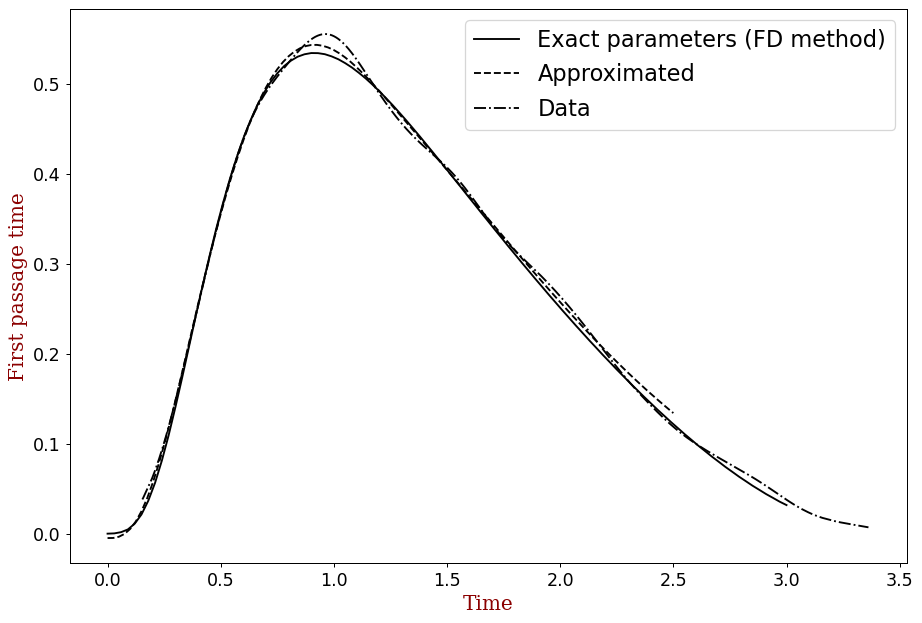

In [12]:
v = 0.7
sigma = 1
def be(rr):
  return 2 - 2*rr/(2*T_inf)

def mu(x,rr):
  r = v/be(rr)-(x*(-2/(2*T_inf)))/be(rr)
  return -r

import numpy as np
import matplotlib.pyplot as plt


def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


# Parameters
L = 2         # Length of the domain
N = 500         # Number of spatial points
T = 3          # Total time
dt = 0.03       # Time step

# Time-dependent diffusion coefficient function

delta = 7.8*10**(-2)


# Spatial grid
x = np.linspace(-1, 1, N)
dx = x[1] - x[0]

# Initial condition: Gaussian distribution
P = 1/(2*np.sqrt(np.pi*delta))*np.exp(-((2*x-0.)**2)/(4*delta))

# Time evolution
timesteps = int(T / dt)
P_all = np.zeros((N,timesteps+1))
P_all[:,0] = P
TT = []
for t in range(timesteps):
    P_new = np.zeros_like(P)
    tt = (t)*dt
    TT.append(tt)
    # Get the current time-dependent diffusion coefficient
    #D_current = D(t * dt)
    a = (-(dt/(4*dx**2))*(sigma/be(tt))**2+(mu(x[1:],tt)*dt)/(4*dx))*np.ones((N-1))
    b = (1+((dt/(2*dx**2)))*(sigma/be(tt))**2)*np.ones((N))
    c = (-(dt/(4*dx**2))*(sigma/be(tt))**2-(mu(x[:-1],tt)*dt)/(4*dx))*np.ones((N-1))
    A = tridiag(a, b, c)


    aa = ((dt/(4*dx**2))*(sigma/be(tt))**2-(mu(x[1:],tt)*dt)/(4*dx))*np.ones((N-1))
    bb = (1-((dt/(2*dx**2)))*(sigma/be(tt))**2)*np.ones((N))
    cc = ((dt/(4*dx**2))*(sigma/be(tt))**2+(mu(x[:-1],tt)*dt)/(4*dx))*np.ones((N-1))
    B = tridiag(aa, bb, cc)
    # Finite difference scheme
    P_new = np.linalg.inv(A) @ B @ P

    # Boundary conditions (Dirichlet or Neumann can be applied here)
    P_new[0] = 0
    P_new[-1] = 0

    P = P_new
    P_all[:,t+1] = P
TT.append((t+1)*dt)
N = 100
def b(t):
   return 2 - 2*t/(2*T_inf)
ddx = 2*b(np.array(TT).reshape((N+1,1))) - 1.98*b(np.array(TT).reshape((N+1,1)))
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

font = {'family': 'serif',
        'color':  'darkred',  # تغییر به رنگ قرمز تیره
        'weight': 'normal',
        'size': 16,
        }


plt.figure(figsize=(12, 8), dpi=90)

p_x_fd = (3*P_all[-1,:] - 4*P_all[-2,:] + P_all[-3,:]) / (ddx[:,0])
J1_fd = mu(2, np.array(TT).reshape((1, N + 1))) * P_all[-1,:] - 0.5 * sigma**2 * p_x_fd
plt.plot(np.array(TT).reshape((N + 1, 1)), np.reshape(J1_fd, (N + 1, 1)), label='Exact parameters (FD method)', color='black')
kde1 = gaussian_kde(rt1)
kde2 = gaussian_kde(rt2)
plt.plot(np.reshape(tspace,(M+1,1)), J1, label='Approximated', color='black', linestyle='--')
plt.plot(rt1-f_p_Identification.tt0f(), len(rt1) * kde1(rt1)[:, np.newaxis] / (len(rt1) + len(rt2)),
         label='Data', color='black', linestyle='-.')


plt.xlabel('Time', fontdict=font)
plt.ylabel('First passage time', fontdict=font)


plt.legend(fontsize=18)


plt.tick_params(axis='both', which='major', labelsize=14)


plt.savefig("ex5-7.pdf", format="pdf", bbox_inches="tight")


plt.show()
